In [1]:
import sqlite3 as sq
import pandas as pd

In [2]:
def connect():
  connection = sq.connect("..\..\FoodHub\db.sqlite3")
  cursor = connection.cursor()

  return connection, cursor

In [3]:
INGREDIENTS = [
  "apple", "banana", "beef", "bread", "broccoli", "butter", "carrot", "cheese", "chicken", "chocolate",
  "cinnamon", "corn", "cucumber", "egg", "eggplant", "fish", "garlic", "ginger", "lemon", "mushroom",
  "olives", "onion", "orange", "parsley", "pasta", "peas", "potato", "rice", "spinach", "tomato"
]

In [4]:
def get_user_ids():
  _, cursor = connect()

  sql = "SELECT DISTINCT user_id FROM cart_order"

  cursor.execute(sql)

  results = cursor.fetchall()
  user_ids = [row[0] for row in results]

  return user_ids

In [5]:
def extract_features(orders_ingredients):
  features = [0] * len(INGREDIENTS)
  
  for order_ingredients in orders_ingredients:
    for i, ingredient in enumerate(INGREDIENTS):
      if ingredient in order_ingredients:
        features[i] += 1

  return features


In [6]:
def get_features_by_user(user_id):
  _, cursor = connect()

  sql = f"SELECT age, gender FROM accounts_user WHERE id = {user_id}"

  cursor.execute(sql)

  age, gender = cursor.fetchone()

  sql = f'''
    SELECT quantity, ingredients, pages_meal.id as meal_id
    FROM cart_order
    INNER JOIN pages_meal ON cart_order.meal_id = pages_meal.id
    WHERE user_id = {user_id}
  '''

  cursor.execute(sql)

  orders = cursor.fetchall()
  
  orders_ingredients_by_user = []
  for quantity, ingredients, meal_id in orders:
    orders_ingredients_by_user.extend([(ingredients, meal_id)] * quantity)

  user_data = []

  for i, order_ingredient in enumerate(orders_ingredients_by_user):
    # exclude the current (i) order
    orders_ingredients = orders_ingredients_by_user[:i] + orders_ingredients_by_user[i+1:]
    orders_ingredients = [order[0] for order in orders_ingredients]
    features = extract_features(orders_ingredients)
    
    # label is meal_id
    label = order_ingredient[1]

    features.extend([age, gender, label])
    user_data.append(features)

  return user_data

In [7]:
def export_csv(data, path):
  columns = INGREDIENTS + ["age", "gender", "label"]

  data = pd.DataFrame(data, columns = columns)
  data.to_csv(path)

In [8]:
data = []
user_ids = get_user_ids()

for user_id in user_ids:
  data.extend(get_features_by_user(user_id))

export_csv(data, "05-dumps/data.csv")

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

In [10]:
data = pd.read_csv("05-dumps/data.csv", index_col = 0)

data.head()

,apple,banana,beef,bread,broccoli,butter,carrot,cheese,chicken,chocolate,...,parsley,pasta,peas,potato,rice,spinach,tomato,age,gender,label
0,0,0,0,2,0,1,0,1,3,0,...,1,0,0,0,0,0,0,24,male,2
1,0,0,0,2,0,1,0,1,3,0,...,1,0,0,0,0,0,0,24,male,2
2,0,0,0,2,0,0,0,2,2,0,...,0,0,0,0,0,0,0,24,male,3
3,0,0,0,1,0,1,0,2,2,0,...,1,0,0,0,0,0,0,24,male,13
4,0,0,0,1,0,1,0,2,2,0,...,1,0,0,0,0,0,0,24,male,13


In [11]:
data["gender"] = data["gender"].apply(lambda x: int(x == "male"))

data.head()

,apple,banana,beef,bread,broccoli,butter,carrot,cheese,chicken,chocolate,...,parsley,pasta,peas,potato,rice,spinach,tomato,age,gender,label
0,0,0,0,2,0,1,0,1,3,0,...,1,0,0,0,0,0,0,24,1,2
1,0,0,0,2,0,1,0,1,3,0,...,1,0,0,0,0,0,0,24,1,2
2,0,0,0,2,0,0,0,2,2,0,...,0,0,0,0,0,0,0,24,1,3
3,0,0,0,1,0,1,0,2,2,0,...,1,0,0,0,0,0,0,24,1,13
4,0,0,0,1,0,1,0,2,2,0,...,1,0,0,0,0,0,0,24,1,13


In [12]:
ingredient_columns = data.columns[:-3]

ingredient_data = dict(data[ingredient_columns].sum(axis = 0))

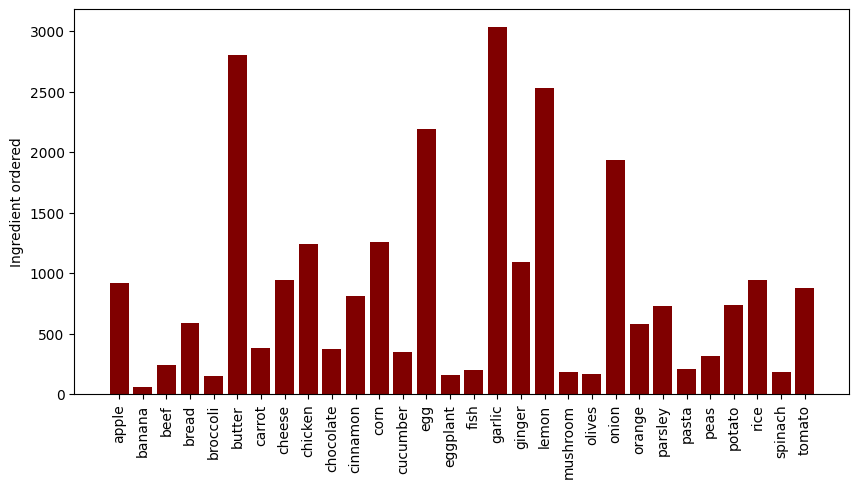

In [13]:
ingredients = list(ingredient_data.keys())
ordered_count = list(ingredient_data.values())

figure = plt.figure(figsize = (10, 5))

plt.bar(ingredients, ordered_count, color = "maroon")
plt.xticks(range(len(ingredients)), ingredients, rotation = "vertical")
plt.ylabel("Ingredient ordered")
plt.show()

In [14]:
features = data.copy()
labels = features.pop("label")

In [19]:
model = keras.Sequential([
  layers.Input(shape = (32, )),
  layers.Dense(32, activation = "relu"),
  layers.Dense(32, activation = "relu"),
  # meals count is 1000
  layers.Dense(1000, activation = "softmax"),
])

In [21]:
model.compile(
  optimizer = keras.optimizers.Adam(1e-3), 
  loss = "sparse_categorical_crossentropy",
  metrics = ["accuracy"]
)

In [22]:
callbacks = [
  keras.callbacks.ModelCheckpoint("05-dumps/epoch-{epoch}.keras")
]

model_output = model.fit(
  features,
  labels,
  epochs = 200,
  batch_size = 2,
  callbacks = callbacks
)

Epoch 1/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0110 - loss: 6.9619
Epoch 2/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0351 - loss: 5.8064
Epoch 3/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0334 - loss: 5.4490
Epoch 4/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0453 - loss: 5.1214
Epoch 5/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0369 - loss: 4.9425
Epoch 6/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0596 - loss: 4.5507
Epoch 7/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0596 - loss: 4.4089
Epoch 8/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0686 - loss: 4.1691
Epoch 9/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0954 - loss: 3.9249
Epoch 10/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1379 - loss: 3.6895
Epoch 11/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1200 - loss: 3.6184
Epoch 12/200
417/417 ━━━━━━━━━━━━━━━━━━━━

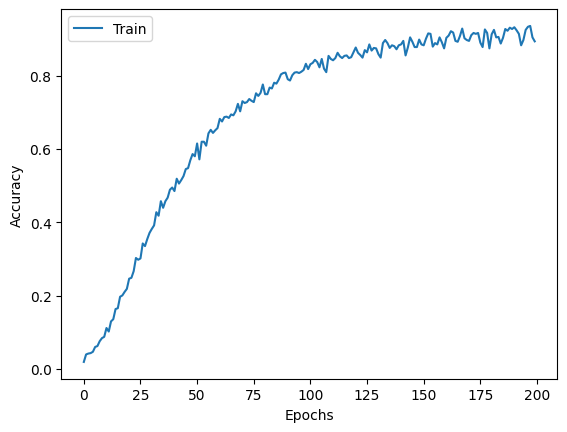

In [23]:
plt.plot(model_output.history["accuracy"], label = "Train")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()